# Capstone 2
## Supervised Learning
### Predicting one-day, high-risk buy-sell advantage for stock market

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ds_useful as ds
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

[My Useful Data Science Functions](https://github.com/cobyoram/python-for-data-scientists/blob/master/ds_useful.py)

In [2]:
# Your key here
key = 'W66EZHH5T8ROHGDP'
# Chose your output format, or default to JSON (python dict)
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

# Get the data, returns a tuple
# aapl_data is a pandas dataframe, aapl_meta_data is a dict
tsla_data, tsla_meta_data = ts.get_daily(symbol='TLSA', outputsize='full')
gm_data, gm_meta_data = ts.get_daily(symbol='GM', outputsize='full')
tm_data, tm_meta_data = ts.get_daily(symbol='TM', outputsize='full')
race_data, race_meta_data = ts.get_daily(symbol='RACE', outputsize='full')

In [3]:
print(tsla_data.shape)
print(gm_data.shape)
print(tm_data.shape)
print(race_data.shape)

(323, 5)
(2338, 5)
(5032, 5)
(1100, 5)


In [4]:
# We'll use the biggest available stock. We are going to use the Toyota Motors data to make our predictions
# While I considered combining datasets to achieve a higher row-count, but I only want to know one company at a time, so that is pointless.
# I also considered increasing the resolution from daily to hourly or bihourly, but the API was misbehaving and truncating my output to a couple hundred rows

car_data = tm_data.reset_index()
car_data

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-03-05,129.50,129.83,128.8007,129.20,401835.0
1,2020-03-04,129.50,131.99,129.0000,131.85,244625.0
2,2020-03-03,132.45,133.99,130.0200,130.95,288993.0
3,2020-03-02,131.00,132.98,130.1400,132.71,264216.0
4,2020-02-28,128.85,130.80,128.0000,130.75,367932.0
...,...,...,...,...,...,...
5027,2000-03-10,89.50,90.56,89.3800,89.69,18100.0
5028,2000-03-09,86.00,86.88,86.0000,86.50,14900.0
5029,2000-03-08,83.75,85.31,83.7500,85.00,39600.0
5030,2000-03-07,83.50,84.13,83.5000,83.50,17500.0


In [5]:
ds.missingness_summary(car_data, print_log=True)
ds.outliers_summary(car_data, print_log = True)
ds.repeats_summary(car_data, value_agg='mode')

5. volume    0.0
4. close     0.0
3. low       0.0
2. high      0.0
1. open      0.0
date         0.0
dtype: float64
5. volume    5.782989
4. close     0.000000
3. low       0.000000
2. high      0.000000
1. open      0.000000
dtype: float64


1. open      0.258347
3. low       0.158983
2. high      0.158983
5. volume    0.119237
4. close     0.099364
date         0.019873
dtype: float64

In [6]:
rename_cols = car_data.columns.str.replace('[0-9]. ', '', regex=True)
rename_map = {col: rename_cols[i] for i, col in enumerate(car_data.columns)}

car_data = car_data.rename(rename_map, axis=1)
car_data

,date,open,high,low,close,volume
0,2020-03-05,129.50,129.83,128.8007,129.20,401835.0
1,2020-03-04,129.50,131.99,129.0000,131.85,244625.0
2,2020-03-03,132.45,133.99,130.0200,130.95,288993.0
3,2020-03-02,131.00,132.98,130.1400,132.71,264216.0
4,2020-02-28,128.85,130.80,128.0000,130.75,367932.0
...,...,...,...,...,...,...
5027,2000-03-10,89.50,90.56,89.3800,89.69,18100.0
5028,2000-03-09,86.00,86.88,86.0000,86.50,14900.0
5029,2000-03-08,83.75,85.31,83.7500,85.00,39600.0
5030,2000-03-07,83.50,84.13,83.5000,83.50,17500.0


In [7]:
# Create a gain interaction variable to show how the price changed throughout the day 
car_data['gain'] = car_data['close'] - car_data['open']
# Create range interaction variable to show the difference between the max and min price
car_data['range'] = car_data['high'] - car_data['low']
# Create a gain interaction variable to show the total gain in company stock value over the day
car_data['total_gain'] = car_data['gain'] * car_data['volume']


In [8]:
# buy_threshold = 0
# car_data['buy'] = np.where(car_data['gain'] > buy_threshold, 1, 0)
# car_data

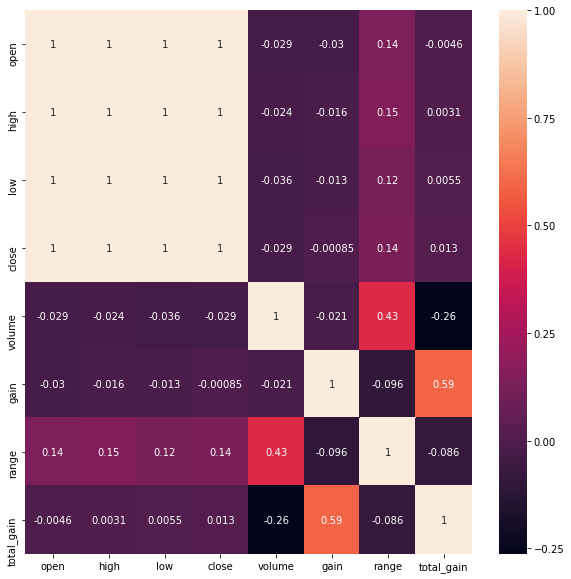

In [9]:
plt.figure(figsize=(10,10))
corr = car_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

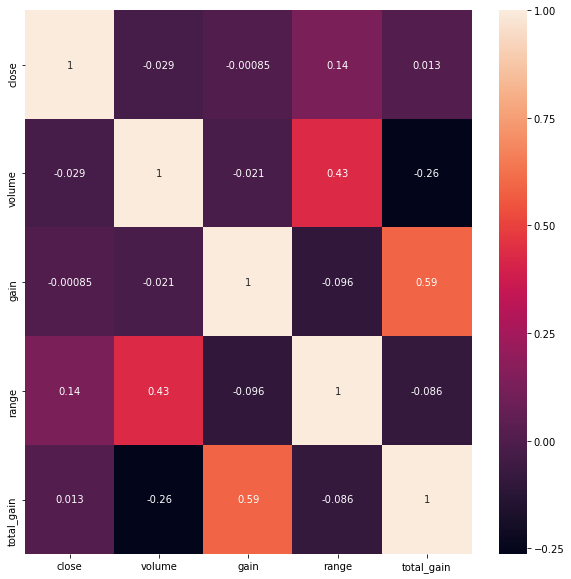

In [10]:
# Since all the base variables (open, high, low, close) are perfectly colinear with each other, we'll remove all but one. We'll keep the close price
collinear_cols = ['high', 'open', 'low']
car_feats = car_data.drop(collinear_cols, axis=1)
plt.figure(figsize=(10,10))
corr = car_feats.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [11]:
# Now we'll add our target variable. We want to try to predict the next day's gain, and whether or not to buy in, based off of a threshold, given the previous 3 days' data.
# First, we'll create three dataframes, set apart only by the date.
three_days_ago = car_feats.copy()
three_days_ago = three_days_ago.drop('date', axis=1).rename(lambda x: '3 ' + x, axis=1)
three_days_ago['date'] = car_feats['date'] + pd.to_timedelta('21 days')
three_days_ago.head()

,3 close,3 volume,3 gain,3 range,3 total_gain,date
0,129.20,401835.0,-0.30,1.0293,-120550.50,2020-03-26
1,131.85,244625.0,2.35,2.9900,574868.75,2020-03-25
2,130.95,288993.0,-1.50,3.9700,-433489.50,2020-03-24
3,132.71,264216.0,1.71,2.8400,451809.36,2020-03-23
4,130.75,367932.0,1.90,2.8000,699070.80,2020-03-20


In [12]:
two_days_ago = car_feats.copy()
two_days_ago = two_days_ago.drop('date', axis=1).rename(lambda x: '2 ' + x, axis=1)
two_days_ago['date'] = car_feats['date'] + pd.to_timedelta('14 days')
two_days_ago.head()

,2 close,2 volume,2 gain,2 range,2 total_gain,date
0,129.20,401835.0,-0.30,1.0293,-120550.50,2020-03-19
1,131.85,244625.0,2.35,2.9900,574868.75,2020-03-18
2,130.95,288993.0,-1.50,3.9700,-433489.50,2020-03-17
3,132.71,264216.0,1.71,2.8400,451809.36,2020-03-16
4,130.75,367932.0,1.90,2.8000,699070.80,2020-03-13


In [14]:
one_day_ago = car_feats.copy()
one_day_ago = one_day_ago.drop('date', axis=1).rename(lambda x: '1 ' + x, axis=1)
one_day_ago['date'] = car_feats['date'] + pd.to_timedelta('7 days')
one_day_ago.head()

,1 close,1 volume,1 gain,1 range,1 total_gain,date
0,129.20,401835.0,-0.30,1.0293,-120550.50,2020-03-12
1,131.85,244625.0,2.35,2.9900,574868.75,2020-03-11
2,130.95,288993.0,-1.50,3.9700,-433489.50,2020-03-10
3,132.71,264216.0,1.71,2.8400,451809.36,2020-03-09
4,130.75,367932.0,1.90,2.8000,699070.80,2020-03-06


In [13]:
today = car_feats[['date', 'gain']]
today.head()

,date,gain
0,2020-03-05,-0.30
1,2020-03-04,2.35
2,2020-03-03,-1.50
3,2020-03-02,1.71
4,2020-02-28,1.90


In [15]:
combined_data = pd.merge(today, one_day_ago, on='date')
combined_data = pd.merge(combined_data, two_days_ago, on='date')
combined_data = pd.merge(combined_data, three_days_ago, on='date')
combined_data

,date,gain,1 close,1 volume,1 gain,1 range,1 total_gain,2 close,2 volume,2 gain,2 range,2 total_gain,3 close,3 volume,3 gain,3 range,3 total_gain
0,2020-03-05,-0.30,131.40,304707.0,-1.76,2.505,-536284.32,139.11,241033.0,0.480,1.1700,115695.84,141.10,135877.0,0.10,0.6766,13587.70
1,2020-03-04,2.35,135.13,316729.0,-0.07,1.660,-22171.03,137.84,315217.0,0.210,1.1595,66195.57,142.43,99055.0,0.43,0.7100,42593.65
2,2020-03-03,-1.50,134.03,317658.0,-2.23,2.960,-708377.34,139.38,275814.0,0.325,1.4200,89639.55,142.11,151169.0,0.12,0.6374,18140.28
3,2020-02-28,1.90,139.04,150574.0,-0.26,1.170,-39149.24,140.15,139167.0,-0.450,1.2350,-62625.15,142.34,98026.0,-0.65,0.9000,-63716.90
4,2020-02-27,-1.76,139.11,241033.0,0.48,1.170,115695.84,141.10,135877.0,0.100,0.6766,13587.70,143.85,204572.0,-0.15,1.3300,-30685.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,2000-03-31,1.00,93.56,41900.0,-0.44,1.630,-18436.00,91.94,10400.0,-0.560,0.8700,-5824.00,89.69,18100.0,0.19,1.1800,3439.00
4519,2000-03-30,-1.62,91.88,21600.0,1.63,1.750,35208.00,92.50,80200.0,1.120,1.6200,89824.00,86.50,14900.0,0.50,0.8800,7450.00
4520,2000-03-29,1.00,90.25,24600.0,-0.50,1.000,-12300.00,88.75,15200.0,-0.310,0.8100,-4712.00,85.00,39600.0,1.25,1.5600,49500.00
4521,2000-03-28,0.88,93.13,47300.0,0.88,1.250,41624.00,89.06,17700.0,-0.570,1.0700,-10089.00,83.50,17500.0,0.00,0.6300,0.00


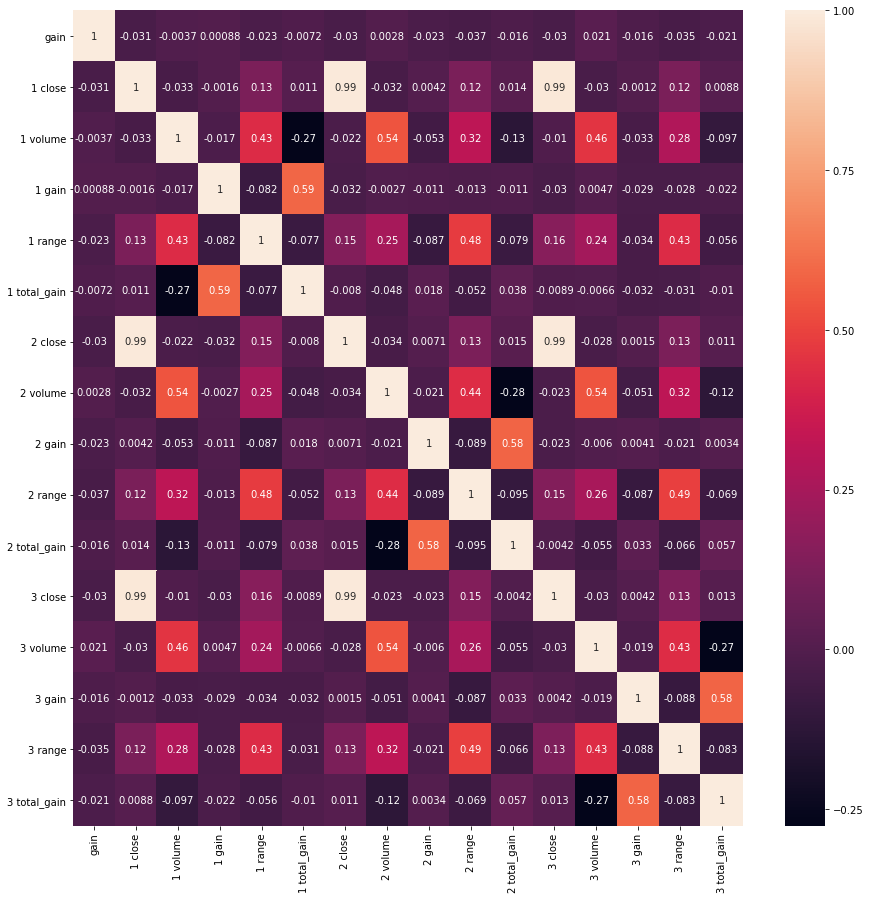

In [16]:
plt.figure(figsize=(15,15))
corr = combined_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

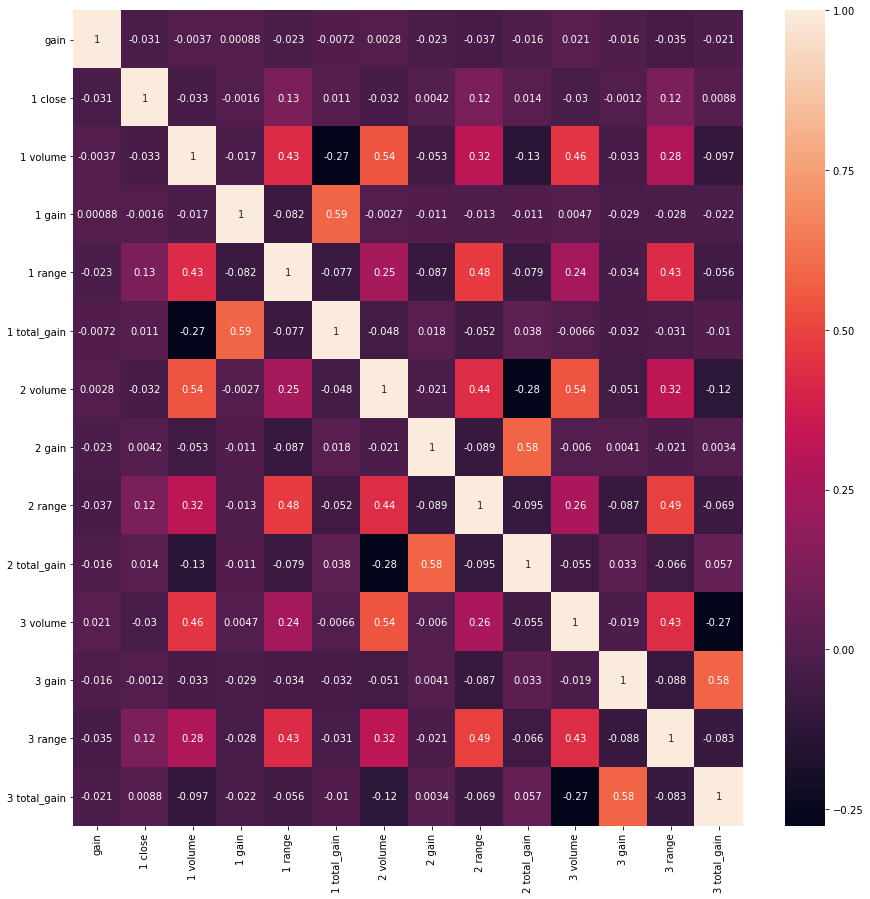

In [17]:
# Since we now have a collinearity issue with closes again, we'll remove all closes except the most recent one
drop_close_cols = ['2 close', '3 close']
com_feats = combined_data.drop(drop_close_cols, axis=1)
plt.figure(figsize=(15,15))
corr = com_feats.corr()
sns.heatmap(corr, annot=True)
plt.show()

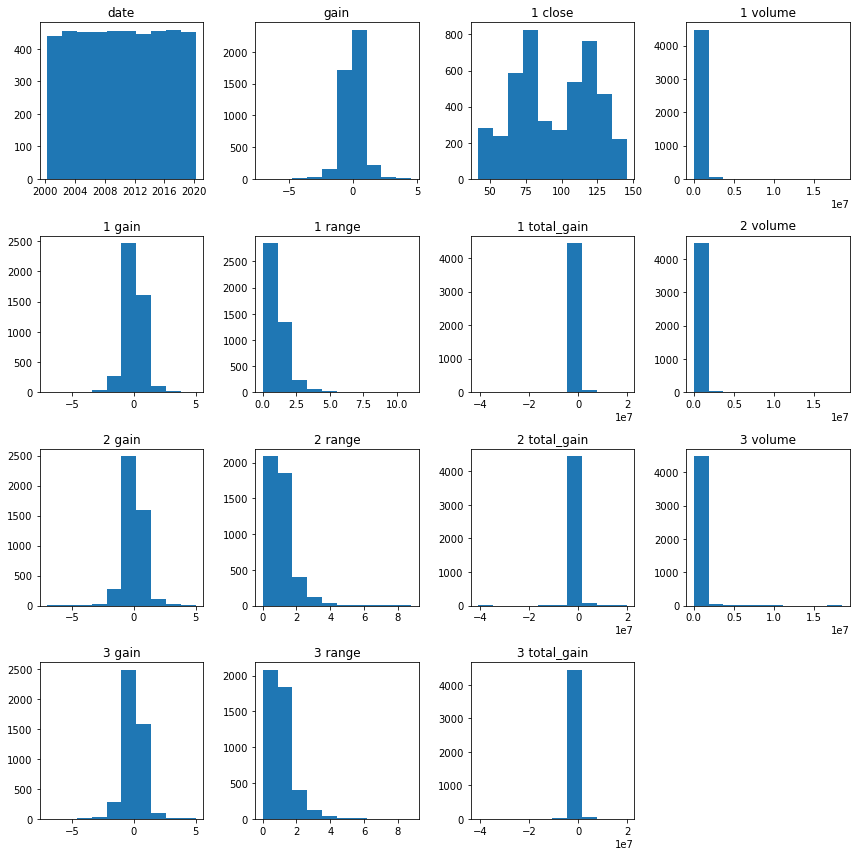

In [18]:
# Let's now take a look at how some of these variables are distributed

def plot(df, col): plt.hist(df[col])

ds.make_subplots(com_feats, plot)

In [19]:
com_feats.head()

,date,gain,1 close,1 volume,1 gain,1 range,1 total_gain,2 volume,2 gain,2 range,2 total_gain,3 volume,3 gain,3 range,3 total_gain
0,2020-03-05,-0.30,131.40,304707.0,-1.76,2.505,-536284.32,241033.0,0.480,1.1700,115695.84,135877.0,0.10,0.6766,13587.70
1,2020-03-04,2.35,135.13,316729.0,-0.07,1.660,-22171.03,315217.0,0.210,1.1595,66195.57,99055.0,0.43,0.7100,42593.65
2,2020-03-03,-1.50,134.03,317658.0,-2.23,2.960,-708377.34,275814.0,0.325,1.4200,89639.55,151169.0,0.12,0.6374,18140.28
3,2020-02-28,1.90,139.04,150574.0,-0.26,1.170,-39149.24,139167.0,-0.450,1.2350,-62625.15,98026.0,-0.65,0.9000,-63716.90
4,2020-02-27,-1.76,139.11,241033.0,0.48,1.170,115695.84,135877.0,0.100,0.6766,13587.70,204572.0,-0.15,1.3300,-30685.80


In [20]:
from sklearn.model_selection import train_test_split

X = com_feats.drop(['gain', 'date'], axis=1)
Y = com_feats['gain']



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 1)

In [21]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [22]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()
lrm.fit(X_train, Y_train)

print(lrm.score(X_train, Y_train))
print(lrm.score(X_test, Y_test))

0.005953285109837725
-0.005221680794589956


In [23]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train)

print(rfr.score(X_train, Y_train))
print(rfr.score(X_test, Y_test))

0.8528654579603089
-0.05221297477141218


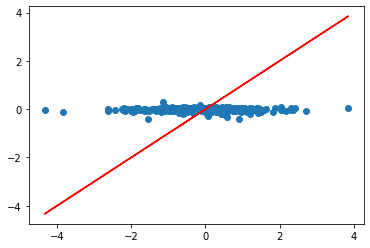

In [24]:
predictions = lrm.predict(X_test)

plt.scatter(Y_test, predictions)
plt.plot(Y_test, Y_test, 'r')

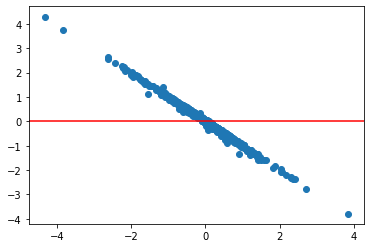

In [25]:
residuals = predictions - Y_test

plt.scatter(Y_test, residuals)
plt.axhline(0, color='r')

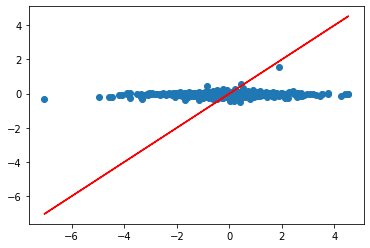

In [26]:
predictions = lrm.predict(X_train)

plt.scatter(Y_train, predictions)
plt.plot(Y_train, Y_train, 'r')

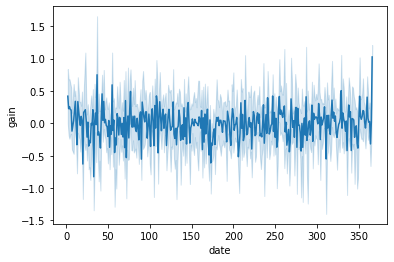

In [27]:
new_com = combined_data.copy()
sns.lineplot(new_com['date'].dt.dayofyear, new_com['gain'])

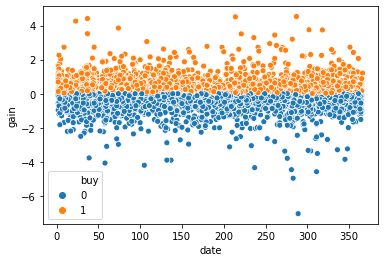

In [28]:
new_com['buy'] = np.where(new_com['gain'] > 0, 1, 0)
sns.scatterplot(new_com['date'].dt.dayofyear, new_com['gain'], hue=new_com['buy'])

In [29]:
car_data

,date,open,high,low,close,volume,gain,range,total_gain
0,2020-03-05,129.50,129.83,128.8007,129.20,401835.0,-0.30,1.0293,-120550.50
1,2020-03-04,129.50,131.99,129.0000,131.85,244625.0,2.35,2.9900,574868.75
2,2020-03-03,132.45,133.99,130.0200,130.95,288993.0,-1.50,3.9700,-433489.50
3,2020-03-02,131.00,132.98,130.1400,132.71,264216.0,1.71,2.8400,451809.36
4,2020-02-28,128.85,130.80,128.0000,130.75,367932.0,1.90,2.8000,699070.80
...,...,...,...,...,...,...,...,...,...
5027,2000-03-10,89.50,90.56,89.3800,89.69,18100.0,0.19,1.1800,3439.00
5028,2000-03-09,86.00,86.88,86.0000,86.50,14900.0,0.50,0.8800,7450.00
5029,2000-03-08,83.75,85.31,83.7500,85.00,39600.0,1.25,1.5600,49500.00
5030,2000-03-07,83.50,84.13,83.5000,83.50,17500.0,0.00,0.6300,0.00


In [30]:
tm_sma, tm_meta_sma = ti.get_sma(symbol=('TM'))

In [31]:
tm_sma_s = pd.Series(tm_sma)
tm_sma_df = tm_sma_s.reset_index().rename({'index': 'date', 0: 'sma'}, axis=1)
tm_sma_df['sma'] = tm_sma_df['sma'].apply(lambda x: x['SMA']).astype('float64')
tm_sma_df['date'] = pd.to_datetime(tm_sma_df['date'])
tm_sma_df

,date,sma
0,2020-03-05,136.9570
1,2020-03-04,137.5830
2,2020-03-03,138.0380
3,2020-03-02,138.4365
4,2020-02-28,138.7430
...,...,...
5008,2000-04-06,95.6420
5009,2000-04-05,95.0545
5010,2000-04-04,94.1295
5011,2000-04-03,93.0995


In [32]:
improved_car_data = pd.merge(car_data, tm_sma_df, on=['date'])
improved_car_data

,date,open,high,low,close,volume,gain,range,total_gain,sma
0,2020-03-05,129.50,129.83,128.8007,129.20,401835.0,-0.30,1.0293,-120550.50,136.9570
1,2020-03-04,129.50,131.99,129.0000,131.85,244625.0,2.35,2.9900,574868.75,137.5830
2,2020-03-03,132.45,133.99,130.0200,130.95,288993.0,-1.50,3.9700,-433489.50,138.0380
3,2020-03-02,131.00,132.98,130.1400,132.71,264216.0,1.71,2.8400,451809.36,138.4365
4,2020-02-28,128.85,130.80,128.0000,130.75,367932.0,1.90,2.8000,699070.80,138.7430
...,...,...,...,...,...,...,...,...,...,...
5008,2000-04-06,98.00,98.63,97.3800,98.25,33600.0,0.25,1.2500,8400.00,95.6420
5009,2000-04-05,103.00,104.00,102.8000,103.50,34000.0,0.50,1.2000,17000.00,95.0545
5010,2000-04-04,104.80,105.30,102.6000,104.10,27500.0,-0.70,2.7000,-19250.00,94.1295
5011,2000-04-03,104.80,105.50,104.1000,104.80,25300.0,0.00,1.4000,0.00,93.0995


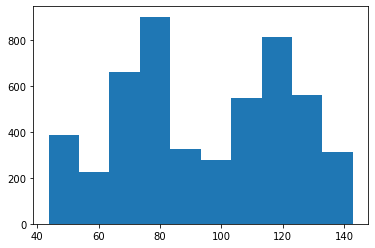

In [33]:
plt.hist(improved_car_data['sma'])
plt.show()

In [34]:
corr = improved_car_data.corr()
corr

,open,high,low,close,volume,gain,range,total_gain,sma
open,1.000000,0.999795,0.999713,0.999577,-0.028956,-0.029960,0.138695,-0.004634,0.993509
high,0.999795,1.000000,0.999612,0.999775,-0.024126,-0.016083,0.149608,0.003133,0.993644
low,0.999713,0.999612,1.000000,0.999771,-0.036292,-0.013433,0.122003,0.005557,0.992825
close,0.999577,0.999775,0.999771,1.000000,-0.029565,-0.000861,0.135956,0.012560,0.993094
volume,-0.028956,-0.024126,-0.036292,-0.029565,1.000000,-0.020481,0.428494,-0.263345,-0.012483
gain,-0.029960,-0.016083,-0.013433,-0.000861,-0.020481,1.000000,-0.096216,0.590686,-0.029568
range,0.138695,0.149608,0.122003,0.135956,0.428494,-0.096216,1.000000,-0.085609,0.164022
total_gain,-0.004634,0.003133,0.005557,0.012560,-0.263345,0.590686,-0.085609,1.000000,-0.006060
sma,0.993509,0.993644,0.992825,0.993094,-0.012483,-0.029568,0.164022,-0.006060,1.000000


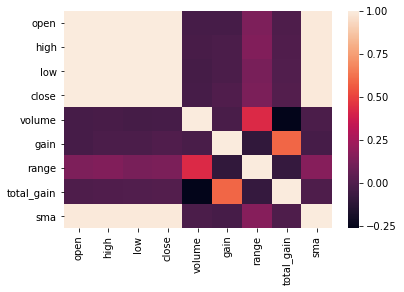

In [35]:
sns.heatmap(corr)

In [36]:
X = improved_car_data.drop(['open','high','low','close','sma', 'date'], axis=1)
Y = improved_car_data['sma']

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [38]:
lrm = LinearRegression()
lrm.fit(X_train, Y_train)

print(lrm.score(X_train, Y_train))
print(lrm.score(X_test, Y_test))

0.038322579621264286
0.022888303092870932


In [39]:
icd_past = improved_car_data[['date']]
icd_past['-1sma'] = [np.nan] + [improved_car_data.loc[i - 1, 'sma'] for i in range(len(improved_car_data)) if i>0]
icd_past

,date,-1sma
0,2020-03-05,NaN
1,2020-03-04,136.9570
2,2020-03-03,137.5830
3,2020-03-02,138.0380
4,2020-02-28,138.4365
...,...,...
5008,2000-04-06,96.0575
5009,2000-04-05,95.6420
5010,2000-04-04,95.0545
5011,2000-04-03,94.1295


In [40]:
icd_future = improved_car_data[['date']]
icd_future['+1close'] = [improved_car_data.loc[i+1, 'close'] for i in range(len(improved_car_data) -1)] + [np.nan]
icd_future['+1open'] = [improved_car_data.loc[i+1, 'open'] for i in range(len(improved_car_data) -1)] + [np.nan]
icd_future

,date,+1close,+1open
0,2020-03-05,131.85,129.50
1,2020-03-04,130.95,132.45
2,2020-03-03,132.71,131.00
3,2020-03-02,130.75,128.85
4,2020-02-28,131.40,133.16
...,...,...,...
5008,2000-04-06,103.50,103.00
5009,2000-04-05,104.10,104.80
5010,2000-04-04,104.80,104.80
5011,2000-04-03,104.00,103.00


In [41]:
icd_merge = pd.merge(icd_future, icd_past, on='date')
icd = pd.merge(improved_car_data, icd_merge, on='date')
icd

,date,open,high,low,close,volume,gain,range,total_gain,sma,+1close,+1open,-1sma
0,2020-03-05,129.50,129.83,128.8007,129.20,401835.0,-0.30,1.0293,-120550.50,136.9570,131.85,129.50,NaN
1,2020-03-04,129.50,131.99,129.0000,131.85,244625.0,2.35,2.9900,574868.75,137.5830,130.95,132.45,136.9570
2,2020-03-03,132.45,133.99,130.0200,130.95,288993.0,-1.50,3.9700,-433489.50,138.0380,132.71,131.00,137.5830
3,2020-03-02,131.00,132.98,130.1400,132.71,264216.0,1.71,2.8400,451809.36,138.4365,130.75,128.85,138.0380
4,2020-02-28,128.85,130.80,128.0000,130.75,367932.0,1.90,2.8000,699070.80,138.7430,131.40,133.16,138.4365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2000-04-06,98.00,98.63,97.3800,98.25,33600.0,0.25,1.2500,8400.00,95.6420,103.50,103.00,96.0575
5009,2000-04-05,103.00,104.00,102.8000,103.50,34000.0,0.50,1.2000,17000.00,95.0545,104.10,104.80,95.6420
5010,2000-04-04,104.80,105.30,102.6000,104.10,27500.0,-0.70,2.7000,-19250.00,94.1295,104.80,104.80,95.0545
5011,2000-04-03,104.80,105.50,104.1000,104.80,25300.0,0.00,1.4000,0.00,93.0995,104.00,103.00,94.1295


In [42]:
icd.dropna(axis=0, inplace=True)

In [43]:
icd['sma_gain'] = icd['sma'] - icd['-1sma']
icd

,date,open,high,low,close,volume,gain,range,total_gain,sma,+1close,+1open,-1sma,sma_gain
1,2020-03-04,129.50,131.99,129.000,131.85,244625.0,2.35,2.990,574868.75,137.5830,130.95,132.45,136.9570,0.6260
2,2020-03-03,132.45,133.99,130.020,130.95,288993.0,-1.50,3.970,-433489.50,138.0380,132.71,131.00,137.5830,0.4550
3,2020-03-02,131.00,132.98,130.140,132.71,264216.0,1.71,2.840,451809.36,138.4365,130.75,128.85,138.0380,0.3985
4,2020-02-28,128.85,130.80,128.000,130.75,367932.0,1.90,2.800,699070.80,138.7430,131.40,133.16,138.4365,0.3065
5,2020-02-27,133.16,133.73,131.225,131.40,304707.0,-1.76,2.505,-536284.32,139.2595,135.13,135.20,138.7430,0.5165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,2000-04-07,98.50,98.50,97.380,98.00,17000.0,-0.50,1.120,-8500.00,96.0575,98.25,98.00,96.7260,-0.6685
5008,2000-04-06,98.00,98.63,97.380,98.25,33600.0,0.25,1.250,8400.00,95.6420,103.50,103.00,96.0575,-0.4155
5009,2000-04-05,103.00,104.00,102.800,103.50,34000.0,0.50,1.200,17000.00,95.0545,104.10,104.80,95.6420,-0.5875
5010,2000-04-04,104.80,105.30,102.600,104.10,27500.0,-0.70,2.700,-19250.00,94.1295,104.80,104.80,95.0545,-0.9250


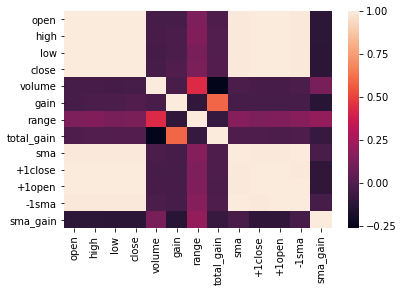

In [44]:
sns.heatmap(icd.corr())

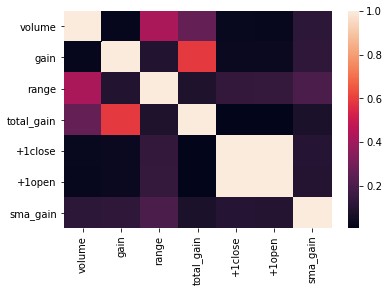

In [45]:
drop_cols = ['-1sma','open','high','low', 'close', 'sma']
icd_feat = icd.drop(drop_cols, axis=1)
sns.heatmap(np.abs(icd_feat.corr()))

In [46]:
X = icd_feat.drop(['date', '+1close'], axis=1)
Y = icd_feat['+1close']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [47]:
lrm = LinearRegression()
lrm.fit(X_train, Y_train)

print(lrm.score(X_train, Y_train))
print(lrm.score(X_test, Y_test))

0.9991829695381806
0.9991421504359633


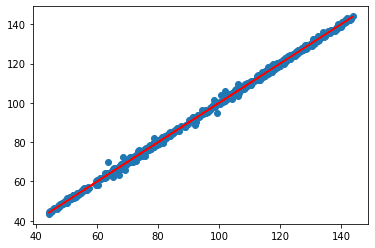

In [48]:
preds = lrm.predict(X_test)

plt.scatter(Y_test, preds)
plt.plot(Y_test, Y_test, 'r')

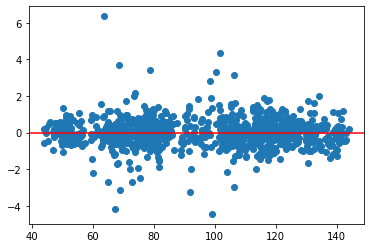

In [49]:
res = preds - Y_test
plt.scatter(Y_test, res)
plt.axhline(0, color='r')

In [131]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, confusion_matrix

def get_action_results(preds, true, features, target, threshold):
    pred_action = np.where(preds - features[target] > threshold, 1, 0)
    true_action = np.where(true - features[target] > threshold, 1, 0)
    return true_action, pred_action

for t in [-1, -.5, -.2, -.1, 0, .1, .2, .5, 1]:
    print('-------------------------------------')
    print('THRESHOLD:', t)
    true_action, pred_action = get_action_results(preds, Y_test, X_test, '+1open', t)

    cm = confusion_matrix(true_action, pred_action)
    print(cm)
    print(accuracy_score(true_action, pred_action))
    print(recall_score(true_action, pred_action))
    print(precision_score(true_action, pred_action))

    pred_action_s = pd.Series(pred_action, index=Y_test.index)
    true_action_s = pd.Series(true_action, index=Y_test.index)
    total = Y_test.loc[pred_action_s == 1] - X_test.loc[pred_action_s == 1]['+1open']

    print(len(total))
    print(total.sum())

-------------------------------------
THRESHOLD: -1
[[  2  75]
 [ 14 912]]
0.9112662013958126
0.9848812095032398
0.9240121580547113
987
-27.570100000000288
-------------------------------------
THRESHOLD: -0.5
[[ 12 187]
 [ 37 767]]
0.7766699900299102
0.9539800995024875
0.8039832285115304
954
-21.15010000000025
-------------------------------------
THRESHOLD: -0.2
[[ 87 270]
 [155 491]]
0.576271186440678
0.760061919504644
0.6452036793692509
761
-6.740100000000211
-------------------------------------
THRESHOLD: -0.1
[[161 260]
 [204 378]]
0.5373878364905285
0.6494845360824743
0.5924764890282131
638
15.149999999999928
-------------------------------------
THRESHOLD: 0
[[282 220]
 [263 238]]
0.518444666001994
0.4750499001996008
0.519650655021834
458
15.269999999999932
-------------------------------------
THRESHOLD: 0.1
[[397 167]
 [286 153]]
0.5483549351944168
0.34851936218678814
0.478125
320
12.999999999999801
-------------------------------------
THRESHOLD: 0.2
[[516 129]
 [276  82]]


In [155]:
new_cols = gm_data.columns.str.replace('[0-9]. ', '', regex=True)
rename_map = {col: new_cols[i] for i, col in enumerate(gm_data.columns)}
car_data = gm_data.reset_index().rename(rename_map, axis=1)
car_data

,index,date,open,high,low,close,volume
0,0,2020-03-05,30.54,30.770,30.010,30.10,17913088.0
1,1,2020-03-04,31.00,31.565,30.355,31.53,16218693.0
2,2,2020-03-03,31.50,32.300,30.260,30.52,15809370.0
3,3,2020-03-02,30.52,31.450,29.740,31.42,14992010.0
4,4,2020-02-28,29.78,30.500,29.330,30.50,20825285.0
...,...,...,...,...,...,...,...
2333,2333,2010-11-24,33.73,33.800,33.220,33.48,26138000.0
2334,2334,2010-11-23,33.95,33.990,33.190,33.25,31170200.0
2335,2335,2010-11-22,34.20,34.480,33.810,34.08,36650600.0
2336,2336,2010-11-19,34.15,34.500,33.110,34.26,107842000.0


In [156]:
# Create a gain interaction variable to show how the price changed throughout the day 
car_data['gain'] = car_data['close'] - car_data['open']
# Create range interaction variable to show the difference between the max and min price
car_data['range'] = car_data['high'] - car_data['low']
# Create a gain interaction variable to show the total gain in company stock value over the day
car_data['total_gain'] = car_data['gain'] * car_data['volume']

In [160]:
gm_sma, gm_meta_sma = ti.get_sma(symbol=('TM'))

In [163]:
gm_data_s = pd.Series(gm_sma)
gm_sma_df = gm_data_s.reset_index().rename({'index': 'date', 0: 'sma'}, axis=1)
gm_sma_df['sma'] = gm_sma_df['sma'].apply(lambda x: x['SMA']).astype('float64')
gm_sma_df['date'] = pd.to_datetime(gm_sma_df['date'])

improved_car_data = pd.merge(car_data, gm_sma_df, on=['date'])
improved_car_data.drop('index', axis=1, inplace=True)
improved_car_data

,date,open,high,low,close,volume,gain,range,total_gain,sma
0,2020-03-05,30.54,30.770,30.010,30.10,17913088.0,-0.44,0.76,-7.881759e+06,136.9570
1,2020-03-04,31.00,31.565,30.355,31.53,16218693.0,0.53,1.21,8.595907e+06,137.5830
2,2020-03-03,31.50,32.300,30.260,30.52,15809370.0,-0.98,2.04,-1.549318e+07,138.0380
3,2020-03-02,30.52,31.450,29.740,31.42,14992010.0,0.90,1.71,1.349281e+07,138.4365
4,2020-02-28,29.78,30.500,29.330,30.50,20825285.0,0.72,1.17,1.499421e+07,138.7430
...,...,...,...,...,...,...,...,...,...,...
2333,2010-11-24,33.73,33.800,33.220,33.48,26138000.0,-0.25,0.58,-6.534500e+06,74.3760
2334,2010-11-23,33.95,33.990,33.190,33.25,31170200.0,-0.70,0.80,-2.181914e+07,73.9750
2335,2010-11-22,34.20,34.480,33.810,34.08,36650600.0,-0.12,0.67,-4.398072e+06,73.6470
2336,2010-11-19,34.15,34.500,33.110,34.26,107842000.0,0.11,1.39,1.186262e+07,73.2915


In [168]:
icd_past = improved_car_data[['date']]
icd_past['-1sma'] = [np.nan] + [improved_car_data.loc[i - 1, 'sma'] for i in range(len(improved_car_data)) if i>0]

icd_future = improved_car_data[['date']]
icd_future['+1close'] = [improved_car_data.loc[i+1, 'close'] for i in range(len(improved_car_data) -1)] + [np.nan]
icd_future['+1open'] = [improved_car_data.loc[i+1, 'open'] for i in range(len(improved_car_data) -1)] + [np.nan]

icd_merge = pd.merge(icd_future, icd_past, on='date')
icd = pd.merge(improved_car_data, icd_merge, on='date')

icd['sma_gain'] = icd['sma'] - icd['-1sma']
icd

,date,open,high,low,close,volume,gain,range,total_gain,sma,+1close,+1open,-1sma,sma_gain
0,2020-03-05,30.54,30.770,30.010,30.10,17913088.0,-0.44,0.76,-7.881759e+06,136.9570,31.53,31.00,NaN,NaN
1,2020-03-04,31.00,31.565,30.355,31.53,16218693.0,0.53,1.21,8.595907e+06,137.5830,30.52,31.50,136.9570,0.6260
2,2020-03-03,31.50,32.300,30.260,30.52,15809370.0,-0.98,2.04,-1.549318e+07,138.0380,31.42,30.52,137.5830,0.4550
3,2020-03-02,30.52,31.450,29.740,31.42,14992010.0,0.90,1.71,1.349281e+07,138.4365,30.50,29.78,138.0380,0.3985
4,2020-02-28,29.78,30.500,29.330,30.50,20825285.0,0.72,1.17,1.499421e+07,138.7430,30.71,31.30,138.4365,0.3065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,2010-11-24,33.73,33.800,33.220,33.48,26138000.0,-0.25,0.58,-6.534500e+06,74.3760,33.25,33.95,74.7375,-0.3615
2334,2010-11-23,33.95,33.990,33.190,33.25,31170200.0,-0.70,0.80,-2.181914e+07,73.9750,34.08,34.20,74.3760,-0.4010
2335,2010-11-22,34.20,34.480,33.810,34.08,36650600.0,-0.12,0.67,-4.398072e+06,73.6470,34.26,34.15,73.9750,-0.3280
2336,2010-11-19,34.15,34.500,33.110,34.26,107842000.0,0.11,1.39,1.186262e+07,73.2915,34.19,35.00,73.6470,-0.3555


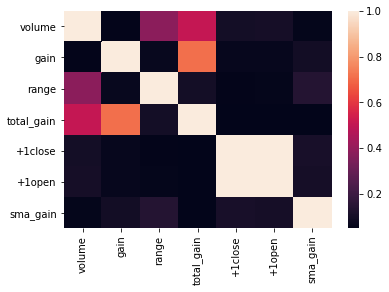

In [169]:
drop_cols = ['-1sma','open','high','low', 'close', 'sma']
icd_feat = icd.drop(drop_cols, axis=1)
sns.heatmap(np.abs(icd_feat.corr()))

In [170]:
X = icd_feat.drop(['date', '+1close'], axis=1)
Y = icd_feat['+1close']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [171]:
preds = lrm.predict(X_test)

for t in [-1, -.5, -.2, -.1, 0, .1, .2, .5, 1]:
    print('-------------------------------------')
    print('THRESHOLD:', t)
    true_action, pred_action = get_action_results(preds, Y_test, X_test, '+1open', t)

    cm = confusion_matrix(true_action, pred_action)
    print(cm)
    print(accuracy_score(true_action, pred_action))
    print(recall_score(true_action, pred_action))
    print(precision_score(true_action, pred_action))

    pred_action_s = pd.Series(pred_action, index=Y_test.index)
    true_action_s = pd.Series(true_action, index=Y_test.index)
    total = Y_test.loc[pred_action_s == 1] - X_test.loc[pred_action_s == 1]['+1open']

    print(len(total))
    print(total.sum())

-------------------------------------
THRESHOLD: -1
[[  3  11]
 [ 10 444]]
0.9551282051282052
0.9779735682819384
0.9758241758241758
455
-11.849900000000044
-------------------------------------
THRESHOLD: -0.5
[[ 10  50]
 [ 45 363]]
0.7970085470085471
0.8897058823529411
0.8789346246973365
413
-9.799900000000036
-------------------------------------
THRESHOLD: -0.2
[[ 69  89]
 [134 176]]
0.5235042735042735
0.567741935483871
0.6641509433962264
265
-8.134900000000027
-------------------------------------
THRESHOLD: -0.1
[[140  59]
 [177  92]]
0.49572649572649574
0.3420074349442379
0.609271523178808
151
-1.794900000000002
-------------------------------------
THRESHOLD: 0
[[215  24]
 [204  25]]
0.5128205128205128
0.1091703056768559
0.5102040816326531
49
0.3601000000000063
-------------------------------------
THRESHOLD: 0.1
[[274   3]
 [186   5]]
0.5961538461538461
0.02617801047120419
0.625
8
2.310000000000006
-------------------------------------
THRESHOLD: 0.2
[[343   1]
 [124   0]]
0.73